In [19]:
import numpy as np
import networkx as nx

G = nx.Graph()
blue, orange, green = '#1f77b4', '#ff7f0e', '#2ca02c'
G.add_nodes_from([
    (1, {'color': blue}),
    (2, {'color': orange}),
    (3, {'color': blue}),
    (4, {'color': green})
])
G.add_edges_from([(1,2), (2,3), (1,3), (3,4)])
A = np.asarray(nx.adjacency_matrix(G).todense())
print(A)

def build_graph_color_label_representation(G, mapping_dict):
    one_hot_idxs = np.array([mapping_dict[v] for v in nx.get_node_attributes(G, 'color').values()])
    one_hot_encoding = np.zeros((one_hot_idxs.size, len(mapping_dict)))
    one_hot_encoding[np.arange(one_hot_idxs.size), one_hot_idxs] = 1
    return one_hot_encoding

X = build_graph_color_label_representation(G, {green: 0, blue: 1, orange: 2})
print(X)

[[0 1 1 0]
 [1 0 1 0]
 [1 1 0 1]
 [0 0 1 0]]
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


C:\Users\cheny\AppData\Local\Temp\ipykernel_3980\699331777.py:13: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.asarray(nx.adjacency_matrix(G).todense())


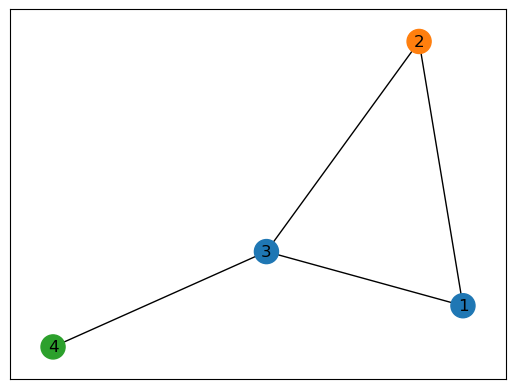

In [22]:
color_map = nx.get_node_attributes(G, 'color').values()
nx.draw_networkx(G, with_labels=True, node_color=color_map)

In [1]:
# Implementing a gnn from scratch
import networkx as nx
import torch
from torch.nn.parameter import Parameter
import numpy as np
import math
import torch.nn.functional as F


class BasicGraphConvolutionLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W2 = Parameter(torch.rand((in_channels, out_channels), dtype=torch.float32))
        self.W1 = Parameter(torch.rand((in_channels, out_channels), dtype=torch.float32))
        self.bias = Parameter(torch.zeros(out_channels, dtype=torch.float32))

    def forward(self, X, A):
        potential_msgs = torch.mm(X, self.W2)
        propagated_msgs = torch.mm(A, potential_msgs)
        root_update = torch.mm(X, self.W1)
        output = propagated_msgs + root_update + self.bias
        return output
    

def global_sum_pool(X, batch_mat):
    if batch_mat is None or batch_mat.dim() == 1:
        return torch.sum(X, dim=0).unsqueeze(0)
    else:
        return torch.mm(batch_mat, X)


class NodeNetwork(torch.nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.conv_1 = BasicGraphConvolutionLayer(input_features, 32)
        self.conv_2 = BasicGraphConvolutionLayer(32, 32)
        self.fc_1 = torch.nn.Linear(32, 16)
        self.out_layer = torch.nn.Linear(16, 2)
    
    def forward(self, X, A, batch_mat):
        x = F.relu(self.conv_1(X, A))
        x = F.relu(self.conv_2(x, A))
        output = global_sum_pool(x, batch_mat)
        output = self.fc_1(output)
        output = self.out_layer(output)
        return F.softmax(output, dim=1)


True